In [1]:
from tqdm import tqdm
import os
from dotenv import load_dotenv
from datasets import load_dataset
load_dotenv()
tqdm.pandas()
from dataset_utils import *
from random import shuffle
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import (
    CommaSeparatedListOutputParser
)
import yaml

config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )

# Loading Dataset

In [2]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df_train = dataset["train"][:]
df_train = df_train.drop(columns=["id"])

int2label = lambda x: dataset["train"].features["labels"].feature.int2str(x)
df_train["labels_text"] = df_train["labels"].apply(int2label)

In [23]:
# samples = df_train[df_train["ds_emotions"].apply(lambda x: "neutral" in x)]
samples = df_train.sample(200, random_state=RANDOM_SEED)

# LLM Labeling

In [24]:
output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()

In [25]:
shuffle(EMOTIONS)
SYSTEM_MESSAGE = f"""You're doing a classification task, given each text, think of the emotion it contains and of its context and try to classify it as one of these emotions {EMOTIONS}
"""

PROMPT_TEMPLATE = f"""
List outputs as {format_instructions}
Input: {{comment}}
"""

final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [26]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [27]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.5

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

In [28]:
import asyncio
import nest_asyncio
from random import shuffle
from concurrent.futures import ThreadPoolExecutor
from tqdm.asyncio import tqdm
from langchain.prompts import ChatPromptTemplate
import openai

# Apply nest_asyncio
nest_asyncio.apply()

def process_sample_sync(index, samples, EMOTIONS, format_instructions, chat):
    shuffle(EMOTIONS)
    SYSTEM_MESSAGE = f"""You're doing a classification task, given each text, think of the emotion it contains and of its context and try to classify it as one of these emotions {EMOTIONS}
    """

    PROMPT_TEMPLATE = f"""
    List outputs as {format_instructions}
    Input: {{comment}}
    """

    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_MESSAGE),
            ("human", PROMPT_TEMPLATE),
        ]
    )
    chain = final_prompt | chat
    comment = samples.loc[index]["text"]
    response = chain.invoke({"comment": comment})  # Assuming chain.invoke is synchronous
    content = response.content
    input_tokens = response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens = response.response_metadata["token_usage"]["completion_tokens"]
    samples.at[index, "predictions"] = content
    return input_tokens, output_tokens

async def generate_predictions(samples, EMOTIONS, format_instructions, chat):
    samples["predictions"] = None
    input_tokens = 0
    output_tokens = 0

    loop = asyncio.get_running_loop()

    with ThreadPoolExecutor() as pool:
        tasks = [
            loop.run_in_executor(
                pool, process_sample_sync, index, samples, EMOTIONS, format_instructions, chat
            )
            for index in samples.index
        ]
        results = await tqdm.gather(*tasks)
    
    for res in results:
        input_tokens += res[0]
        output_tokens += res[1]

    input_tokens = input_tokens / len(samples)
    output_tokens = output_tokens / len(samples)

    return samples, input_tokens, output_tokens

# To call the function in a Jupyter notebook or other environment with an active event loop:
samples, input_tokens, output_tokens = await generate_predictions(samples, EMOTIONS, format_instructions, chat)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


In [17]:
samples.to_csv("new_prompt_preds.csv", index=False)

# Evaluation

In [18]:
samples = pd.read_csv("new_prompt_preds.csv")

Results for llama-v3-70b-instruct:
Average BCE Loss: 0.7100
Average F1 Score: 0.5290
Average Precision: 0.5475
Average Recall: 0.5827
Average Distance: -0.3488
Total Distance: -69.7595


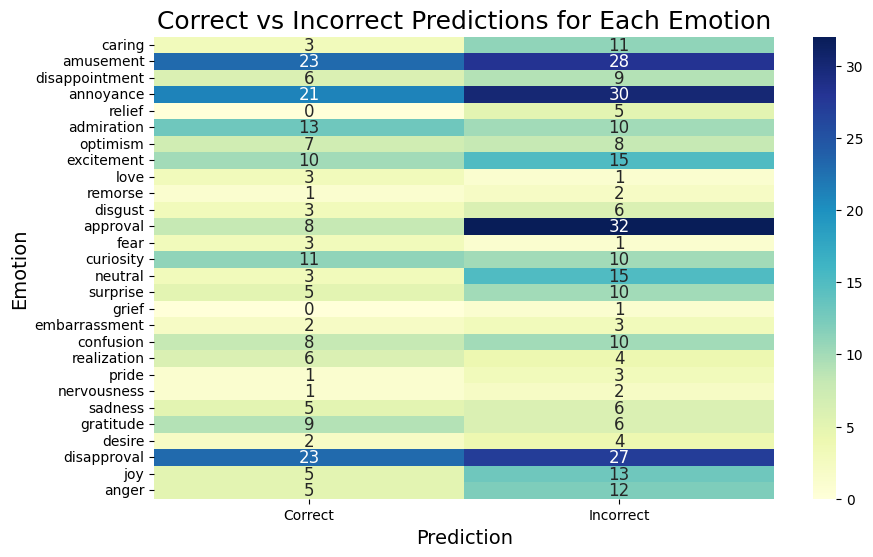

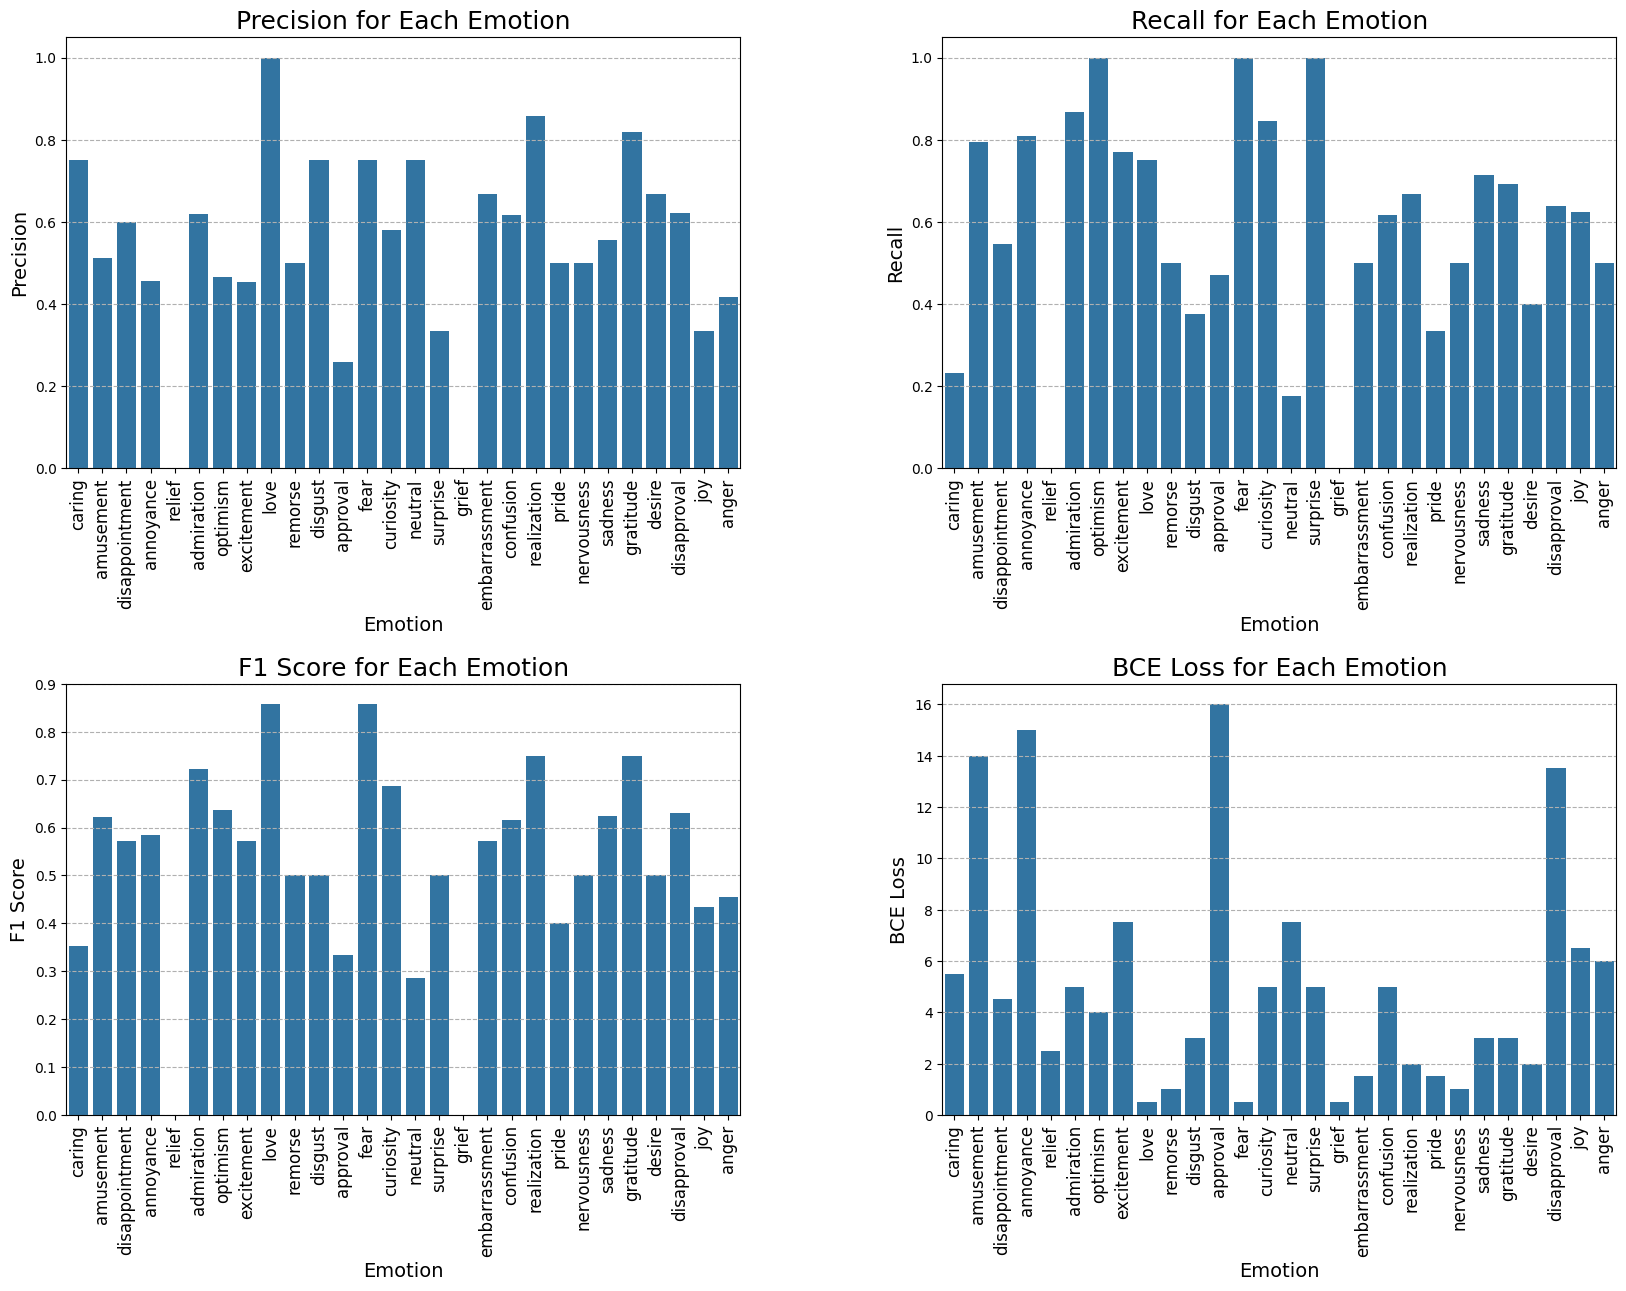

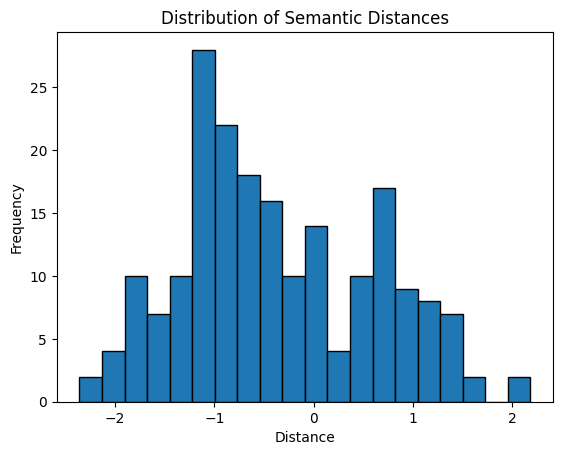

In [22]:
predicted_labels = samples["predictions"]
predicted_labels = pd.Series([p.split(", ") for p in predicted_labels])
predicted_labels = predicted_labels.apply(lambda x: [re.sub(r"\s+", "", label) for label in x])
ground_truth_labels = pd.read_csv("gt.csv", encoding="latin-1")
ground_truth_labels = ground_truth_labels
ground_truth_labels = ground_truth_labels["ground_truth"]
kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": 0,
    "avg_output_tokens": 0,
    # Additional Kwargs
    "ensemble": 1,
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    ground_truth_labels,
    EMOTIONS,
    samples["text"],
    verbose=True,
    ## IMPORTANT ##
    trial_num=3,  # Change this for each trial, visualization will be according to this number
    ################
    distances_save_name="prediction_distances.csv",
    **kwargs
)

In [146]:
# count the total number of correct in the first trail in the json file
with open("results.json", "r") as f:
    results = json.load(f)
    correct = 0
    incorrect = 0
    scores = results[7]["scores"]  # Access the scores part of the JSON
    for emotion, metrics in scores.items():
        if emotion != "average":  # Skip the average key
            correct += metrics["correct"]
            incorrect += metrics["incorrect"]
    print(f"Correct: {correct}")
    print(f"Incorrect: {incorrect}")

Correct: 191
Incorrect: 324


In [26]:
# count total number of labels in the ground truth csv
total = 0
for label in ground_truth_labels:
    total += len(label.split(","))

print(f"Total: {total}")

Total: 294
